In [ ]:
# import libraries for EDA
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from rdkit import Chem
from rdkit.Chem import Draw
from mordred import descriptors, Calculator
from molml.features import CoulombMatrix

In [2]:
# Load dataset from Data wrangling
df = pd.read_csv('processed_data.csv')
df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_atoms,num_heavy_atoms,canonical_smile
0,3.69951,1.23093,1.09709,5.0509,78.30,-0.2676,0.0141,0.2818,1120.8417,0.137571,-380.79782,-380.79050,-380.78955,-380.82970,28.666,N#CC1NC11C2CC1C2,<rdkit.Chem.rdchem.Mol object at 0x3abc242e0>,17,9,N#CC1NC12C1CC2C1
1,3.58161,1.13798,0.87264,2.5256,55.40,-0.2868,-0.0597,0.2271,1180.5099,0.064339,-525.78340,-525.77594,-525.77496,-525.81620,25.955,OC1=NON=C1OC=O,<rdkit.Chem.rdchem.Mol object at 0x3abc24510>,11,9,O=COc1nonc1O
2,2.35658,1.75261,1.52228,1.5279,83.85,-0.2229,0.0807,0.3036,1029.1179,0.196525,-367.18655,-367.17874,-367.17780,-367.21826,32.345,CC12CCC1CN1CC21,<rdkit.Chem.rdchem.Mol object at 0x3abc24580>,22,9,CC12CCC1CN1CC12
3,2.20077,1.50794,0.92898,2.1100,72.11,-0.2575,-0.0123,0.2451,1230.8475,0.136089,-455.19177,-455.18280,-455.18185,-455.22604,32.000,CN=C1OC(=O)CC1N,<rdkit.Chem.rdchem.Mol object at 0x3abc245f0>,17,9,CN=C1OC(=O)CC1N
4,2.43658,1.01176,0.74884,2.7860,75.68,-0.2791,0.0257,0.3048,1496.1036,0.168867,-440.29135,-440.28058,-440.27963,-440.32758,37.969,CC(CO)C(CO)C#N,<rdkit.Chem.rdchem.Mol object at 0x3abc24660>,20,9,CC(CO)C(C#N)CO


Questions to ask in EDA:
1. What are the main clusters according to the atomic number?
2. How are the properties distributed in these clusters?
3. What is the distribution of heavy atoms in each molecule?
4. How are the properties distributed according to the number of heavy atoms?
5. What molecular descriptors can be used to represent the molecules?
6. What type of molecular descriptors yelds the best property prediction?

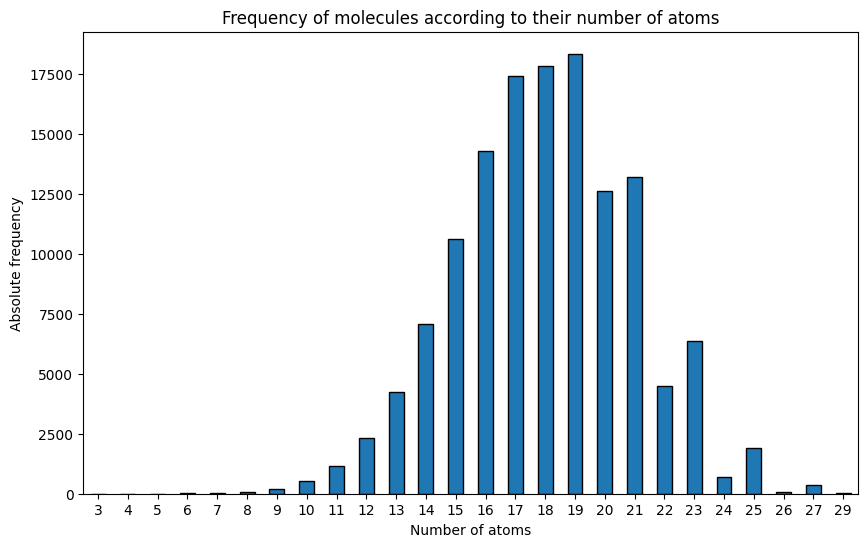

In [3]:
# Checking the counts of molecules, depending on their atom counts
df['num_atoms'].value_counts().sort_index().plot.bar(figsize=(10,6), rot=0, edgecolor='k')
plt.title("Frequency of molecules according to their number of atoms")
plt.xlabel('Number of atoms')
plt.ylabel('Absolute frequency')
plt.show()

# Kinda follows normal distribution

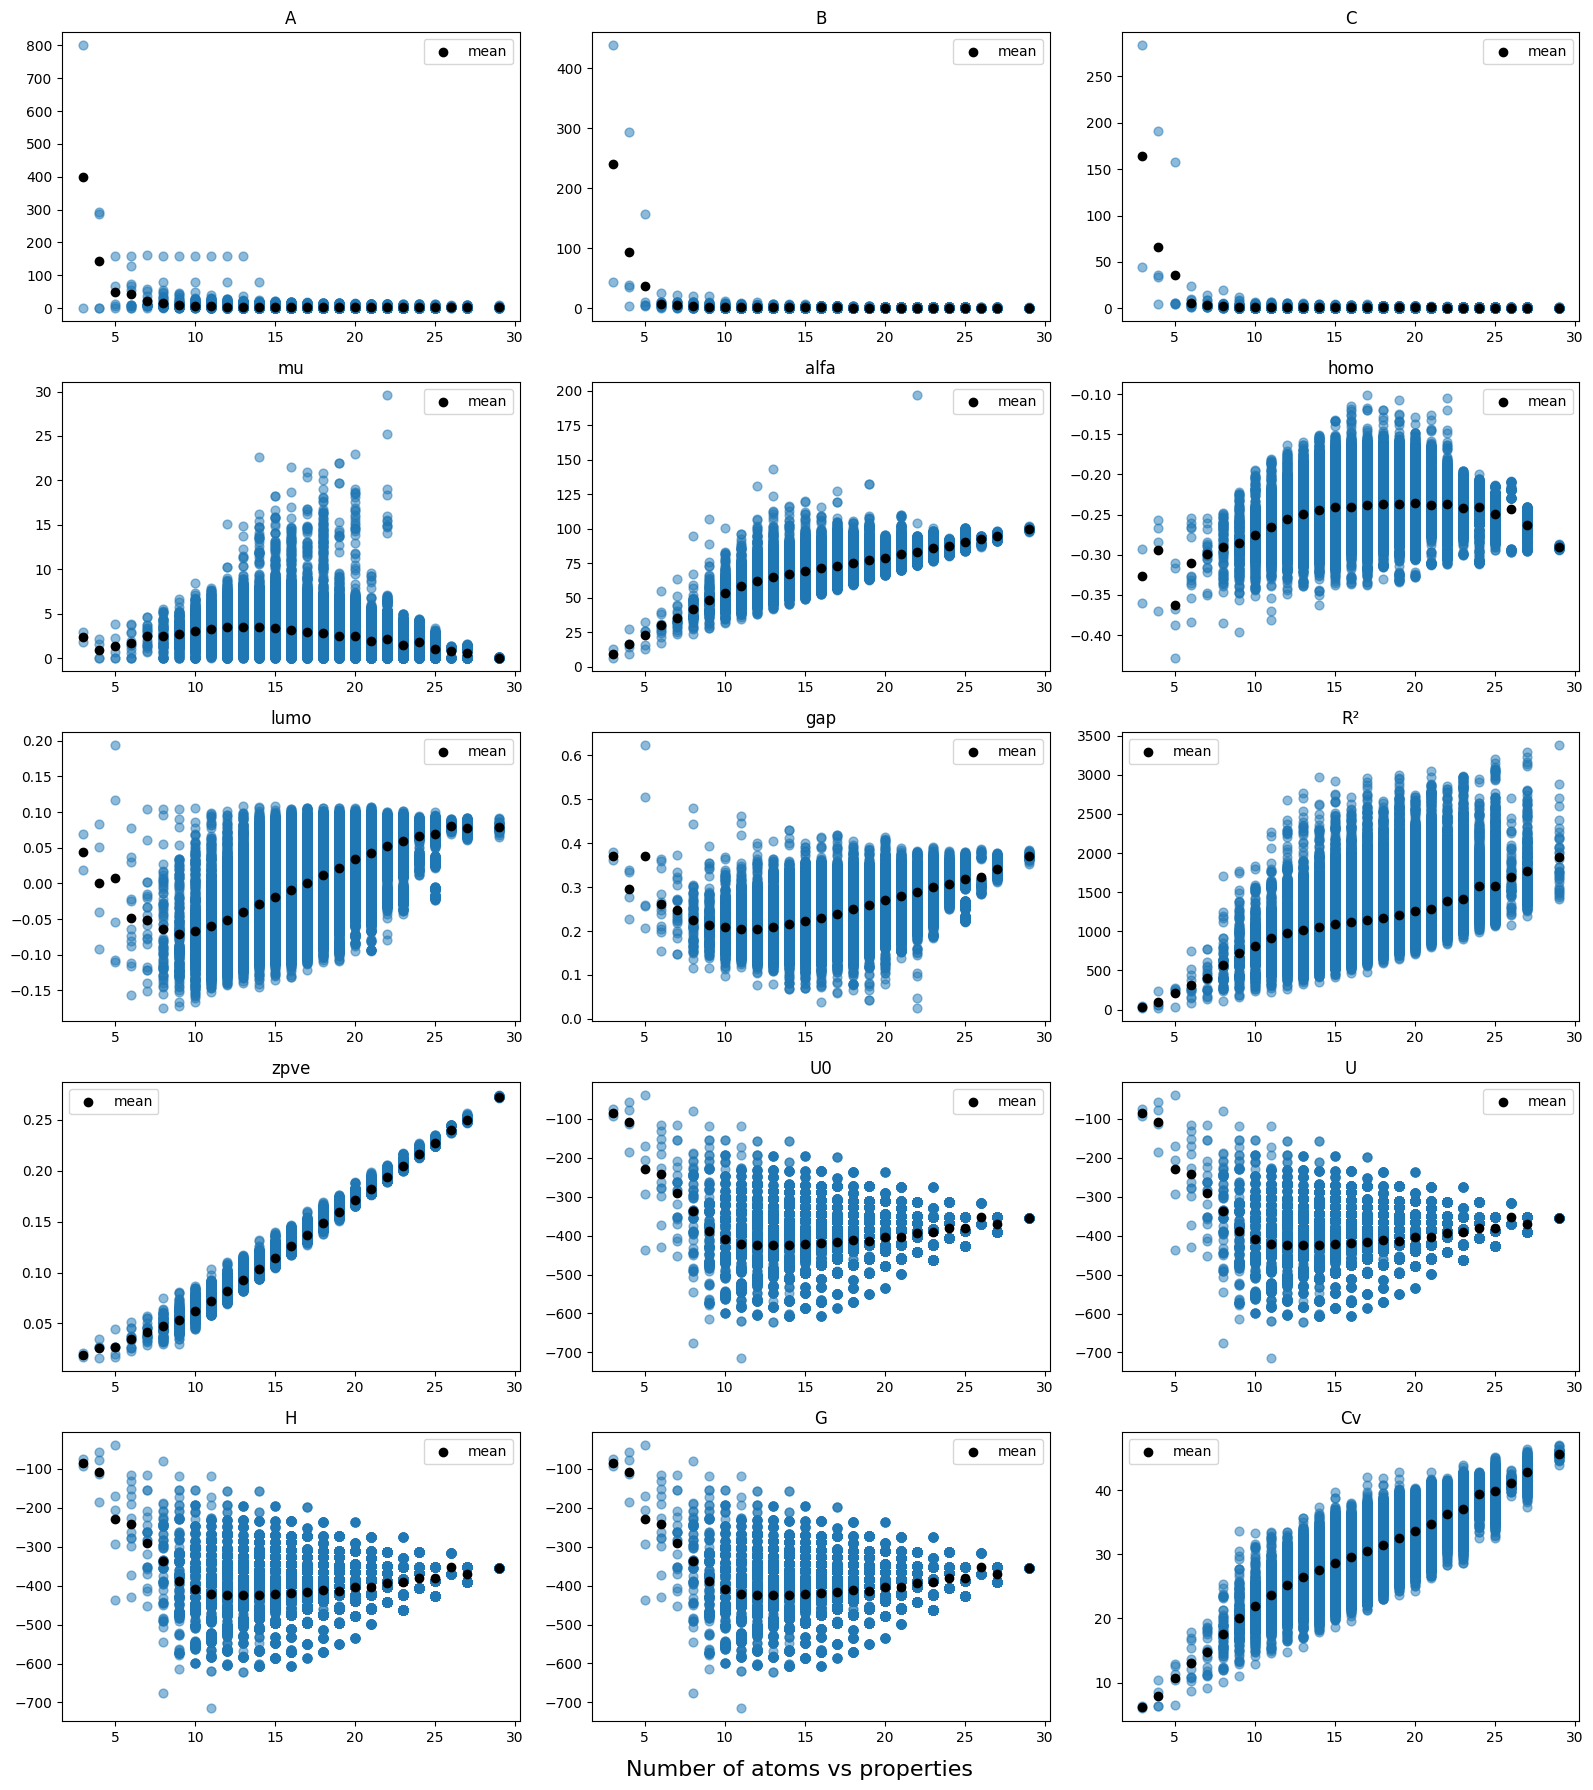

In [4]:
# Checking property distribution along the number of atoms in the molecule
plt.figure(figsize=(16, 18))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(5, 3, plot_counter)
    plt.scatter(df['num_atoms'],df[prop],s=40, alpha = 0.5) # s = size of the marker
    for atom in np.unique(df['num_atoms']):
        plt.scatter(atom, df[prop][df['num_atoms'] == atom].mean(), c='k',label='mean') # c = color
        # Plotting the mean value of a property for molecules that have a specific number of atoms

    handles, labels = plt.gca().get_legend_handles_labels() # gca = get current axis, manually captures the current legend entries 
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(prop)
    plot_counter = plot_counter + 1
plt.suptitle('Number of atoms vs properties', x=0.5, y=0, ha='center', size=16) 
plt.tight_layout()
plt.show()

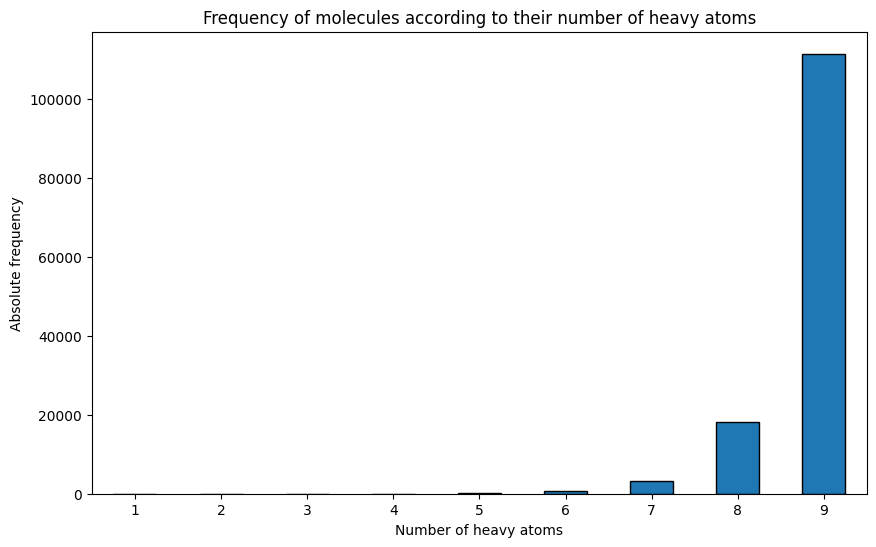

In [5]:
# Checking the counts of molecules, depending on their heavy atom counts
df['num_heavy_atoms'].value_counts().sort_index().plot.bar(figsize=(10,6), rot=0, edgecolor='k')
plt.title("Frequency of molecules according to their number of heavy atoms")
plt.xlabel('Number of heavy atoms')
plt.ylabel('Absolute frequency')
plt.show()


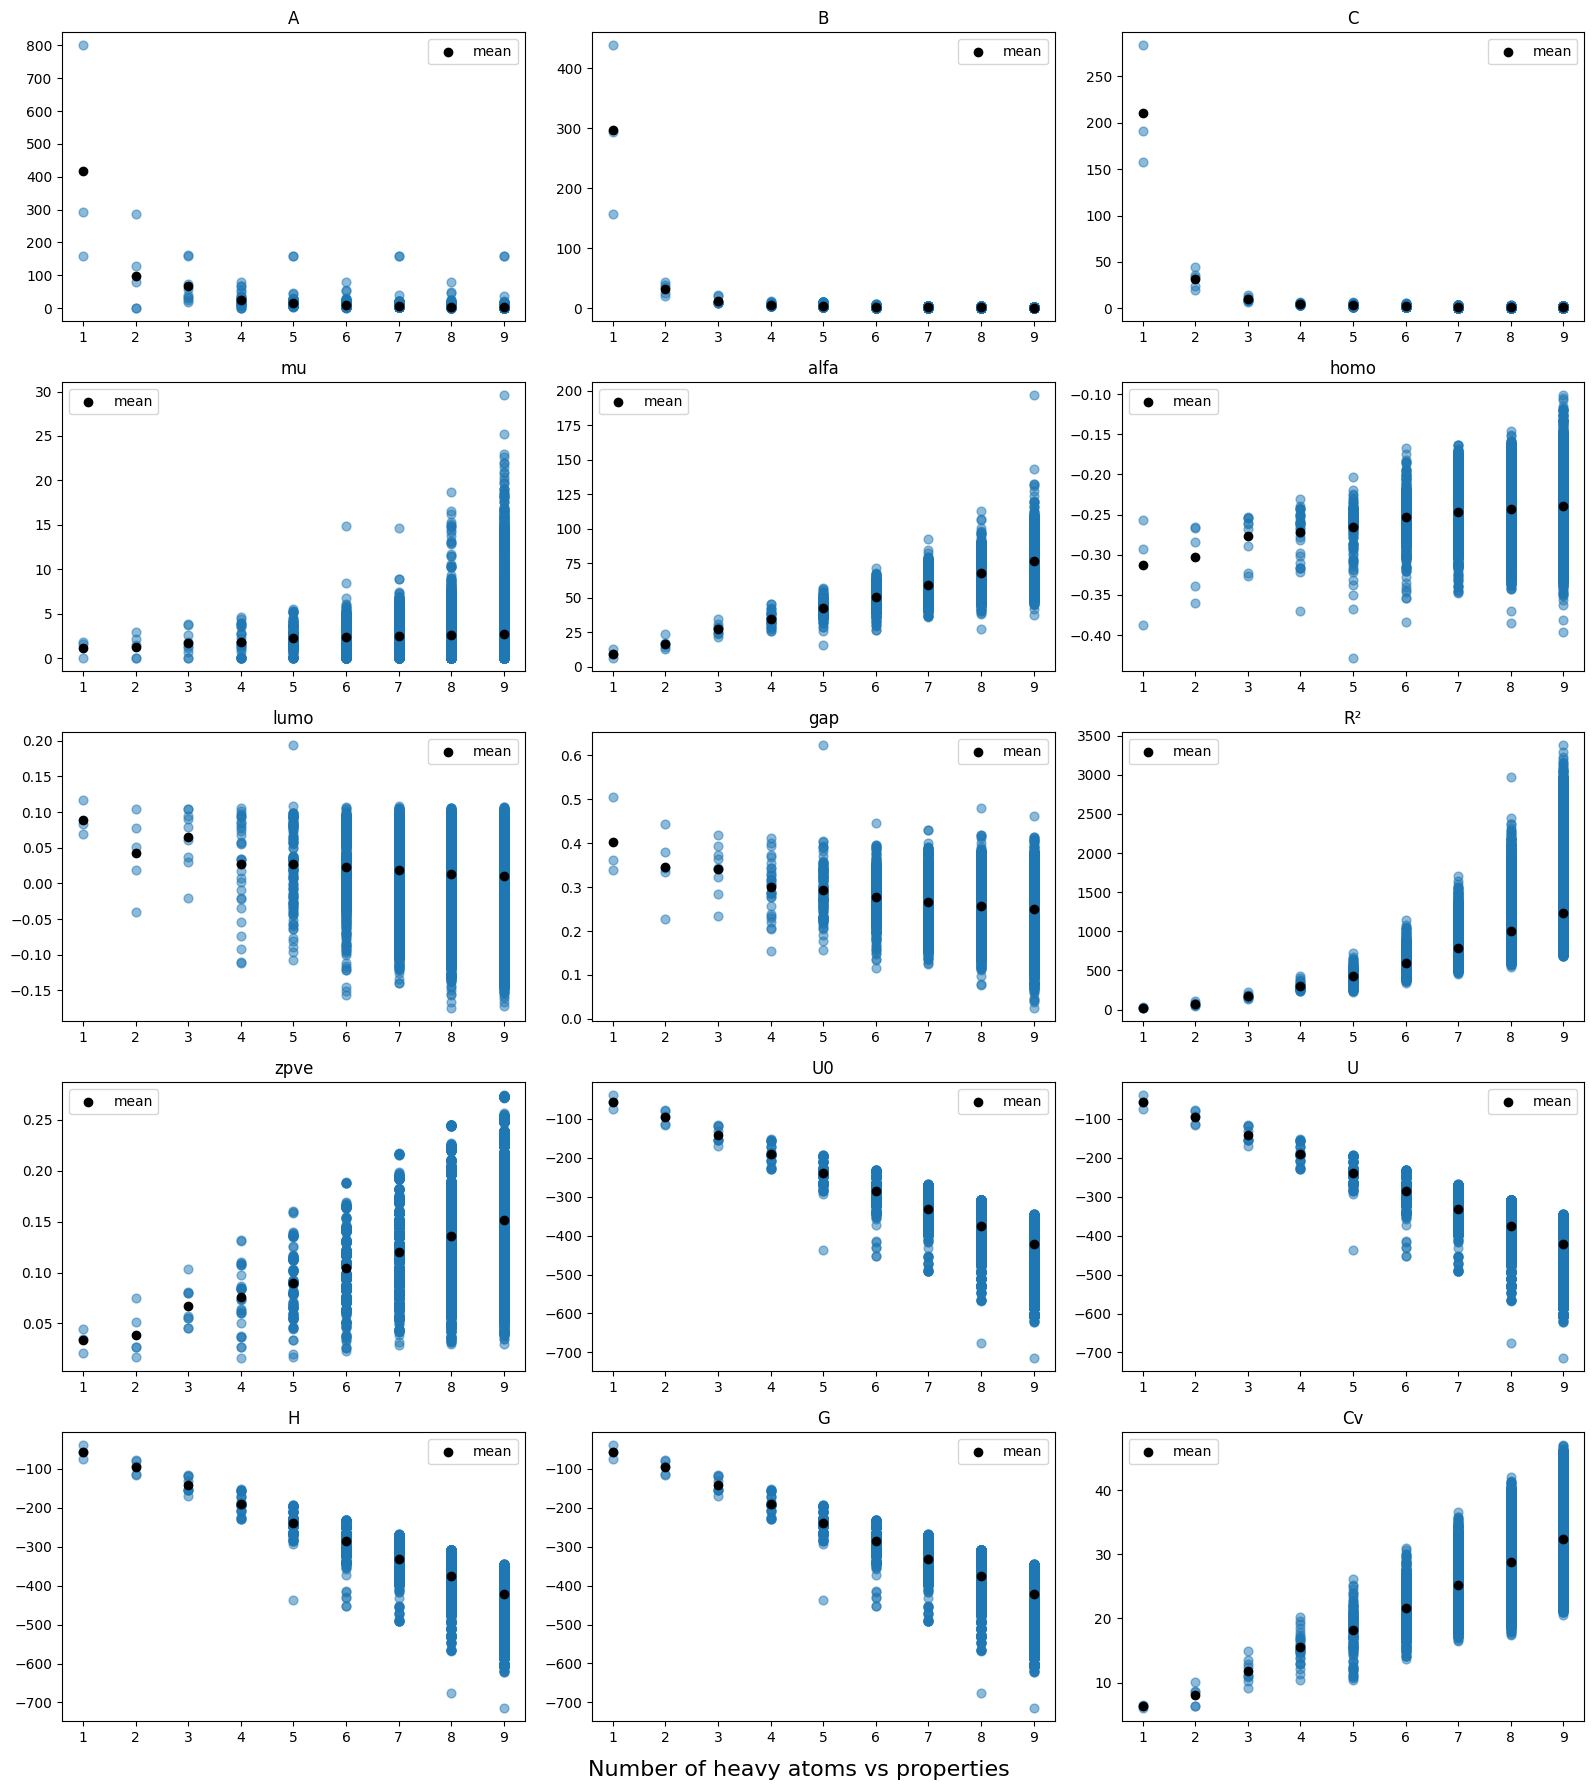

In [6]:
# Distribution of properties based on number of heavy atoms
plt.figure(figsize=(16, 18))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(5, 3, plot_counter)
    plt.scatter(df['num_heavy_atoms'],df[prop],s=40, alpha = 0.5) # s = size of the marker
    for atom in np.unique(df['num_heavy_atoms']):
        plt.scatter(atom, df[prop][df['num_heavy_atoms'] == atom].mean(), c='k',label='mean') # c = color
        # Plotting the mean value of a property for molecules that have a specific number of atoms

    handles, labels = plt.gca().get_legend_handles_labels() # gca = get current axis, manually captures the current legend entries 
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(prop)
    plot_counter = plot_counter + 1
plt.suptitle('Number of heavy atoms vs properties', x=0.5, y=0, ha='center', size=16) 
plt.tight_layout()
plt.show()

Numerical values of descriptors quantify pyhsiochemical information of molecule. (Somewhat like referece) 
Two types of descriptors:
- Experimental: values measured in labs
- Theoretical: values calculated from molecular structure --> data from SMILES strings 

Will use SMILES to calculate the theoretical descriptors and compare with the experimental descriptors (properties) that were loaded on the dataset.
Inputing the Mol object (that was derived from SMILES string) into the Caclulator function, returns SMILES derived theoretical descriptors.
The theoretical descriptors will be stored on a seperate csv file. 


In [13]:
# Due to memory issue, will focus on molecules with 19 atoms
#df['mol'] = df['smiles'].apply(Chem.MolFromSmiles) # re-instantizing mol object, not sure why not work without..
df_19 = df[df['num_atoms'] == 19]
mol_19 = df_19['mol'].to_list()

calc = Calculator(descriptors, ignore_3D=True) # Initializing Mordred descriptor calculator
# Skipping 3D because SMILES string do not contain 3D structure by default

# calc input is expected to be list-like iterables of RDKitMol obejcts
# pandas() function calculates molecular descriptors for a list of RDKit Mol objects and returns the result as a pandas DataFrame.
df_desc = calc.pandas(mol_19, nproc=1)

# Save the results in csv file
df_desc.to_csv("descriptors.csv")



In [ ]:
df_desc.info()

<class 'mordred._base.pandas_module.MordredDataFrame'>
RangeIndex: 18333 entries, 0 to 18332
Columns: 1613 entries, ABC to mZagreb2
dtypes: bool(2), float64(943), int64(326), object(342)
memory usage: 225.4+ MB


In [ ]:
df_desc.loc[:,df_desc.dtypes == object] # Filters for columns (theoretical descriptors) that are non-numerical objects
# Non-numerical descriptors are typically not wanted in machine learning
# Can be thought as "failed descriptors"

,ABC,ABCGG,AATS6dv,AATS7dv,AATS8dv,AATS6d,AATS7d,AATS8d,AATS6s,AATS7s,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0.0,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,1.0,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,2.25,invalid value encountered in scalar divide (AA...,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),0.333333,float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0.0,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,1.0,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,4.0,invalid value encountered in scalar divide (AA...,...,float division by zero (MDEC-44),0.25,float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0.0,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,1.0,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,1.0,invalid value encountered in scalar divide (AA...,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),1.144714,float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0.0,0.0,invalid value encountered in scalar divide (AA...,1.4,1.0,invalid value encountered in scalar divide (AA...,2.0,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,invalid value encountered in scalar divide (AA...,...,1.0,float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18328,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0.869565,0.0,0.0,1.521739,1.133333,1.0,2.362319,2.4,...,float division by zero (MDEC-44),0.2,0.816497,float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22)

In [ ]:
# Will be filtering only numerical descriptors and saving them as floats
df_desc = df_desc.select_dtypes(include=np.number).astype('float32')

# Remove zero-variance descriptors; meaning they have the same value for every molecule, and this is useless
df_desc = df_desc.loc[:, df_desc.var() > 0.0]

# Normalize descriptors
ml_df = pd.DataFrame(MinMaxScaler().fit_transform(df_desc), columns = df_desc.columns)


       nAcid  nBase   SpAbs_A   SpMax_A  SpDiam_A    SpAD_A   SpMAD_A  \
0        0.0   0.25  0.632654  0.282702  0.312114  0.632654  0.520152   
1        0.0   0.00  0.577712  0.344103  0.324511  0.577712  0.448385   
2        0.0   0.00  0.718230  0.461089  0.392428  0.718230  0.631937   
3        0.0   0.25  0.445863  0.411582  0.285618  0.445863  0.497206   
4        0.0   0.00  0.774736  0.882543  0.615138  0.774736  0.705747   
...      ...    ...       ...       ...       ...       ...       ...   
18328    0.0   0.00  0.655759  0.345513  0.261054  0.655759  0.550333   
18329    0.0   0.00  0.606835  0.561208  0.619596  0.606835  0.486427   
18330    0.0   0.00  0.587318  0.550382  0.607644  0.587318  0.460932   
18331    0.0   0.25  0.684768  0.514773  0.523119  0.684768  0.588227   
18332    0.0   0.00  0.574154  0.342334  0.275092  0.574154  0.443737   

        LogEE_A     VE1_A     VE2_A  ...     SRW10    TSRW10        MW  \
0      0.406013  0.762119  0.432482  ...  0.36284

In [27]:
# Saving ml_df as a training dataset
ml_df.to_csv("ml_df.csv")

In [28]:
# Saving property csv for molecules that have atom counts equal to 19
df_19.to_csv('df_19.csv')